## Errors in radius

This notebook is TODO: Combine applications_dt with notebook 04.

Bugs: 

- Inertial instability: valid_ids[0]

- K < 1 (e.g K = 0.1): valid_ids[2] ==> Choose Vmax > 33 m/s? i.e the TCs need to be wel formed. Otherwise for the weakening phase I will get trouble.

TODO:

- Take RMSE on real SAR image, not Holland profile ==> complicated because not the same x-axis.

In [1]:
# General
import glob
import re
import os.path
import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LinearSegmentedColormap

# Data treatment
from datetime import datetime
from scipy.optimize import curve_fit

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PRMS = {
    'n':              5, # R+ is defined as omega(R+) = n * f
    'sav_fgs':        False,
    'sav_dat':        False,
}

PTHS = {
    'dsg_pth':         '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
    'sct_dir':         '/home/arthur/data/scatterometer/KNMI/product_JF_rotated_filtered_v3/POLAR/2020/EP182020/',
    'sav_dir':         '/home/arthur/results/TCsLifeMonitFromObs/PRJCT_TIME_EVOLUTION/05_ERROR_IN_RADIUS/'
}

### 1) Functions and model

In [3]:
# COLORMAP
colors = [mpl.colors.to_rgb('k'), mpl.colors.to_rgb('orangered')] # first color is black, last is red
cm     = LinearSegmentedColormap.from_list("Custom", colors, N=20)

In [4]:
### RESOLUTION
rs = np.linspace(10, 900000, 90000)
dr = 10 # meters

### FUNCTIONS
def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def holland_profile(r, lat, pn, pc, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    fcor  = abs(coriolis(lat))
    rho   = 1.15
    B     = ((Vmax - Vmin) ** 2) * rho * np.e / (pn - pc)
    A     = Rmax ** B
    
    r     = r.astype(float) + 0.001 # To avoid dividing by zero
    V     = r * 0.
    V     = Vmin + np.sqrt(A * B * (pn - pc) * np.exp((-1) * A / (r ** B)) / (rho * r ** B) + (r ** 2 * fcor ** 2) / 4) - (r * fcor / 2)
    return V

def vorticity(r, v):
    '''Relative vorticity'''
    return (1 / r) * np.gradient(r * v, dr)

def N(r, M):
    '''Rotational stability frequency'''
    # try:
    N2 = np.gradient(M ** 2, dr) / (r ** 3)
    if np.count_nonzero(N2 < 0) > 0:
        raise InertiallyUnstableError
    else:
        return np.sqrt(N2)
    # except InertiallyUnstableError:
    #     print("Inertially unstable wind profile in function N()")

def v_k10(v0, t, lbda=None):
    # Initial
    v          = np.zeros_like(v0.rad)                     # Raw v0
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)})    # Inner-core: v0 interpolated on r * e^t
    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category=RuntimeWarning)
        nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t)) # Near-core (1)
    v_prop_nr  = v0.interp({'rad': nr_term})               # Near-core (2)
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)              # Outer-core (1)
    v_prop_ou  = v0.interp({'rad': ou_term})               # Outer-core (2)
    
    # No friction
    if lbda is None:
        vin        = v_prop_in * np.exp(t) + v0.rad * (np.exp(2 * t) - 1) / 2                                      # Inner-core
        vnr        = nr_term * v_prop_nr / v0.rad + (1 - v0.rad ** 2) / (2 * v0.rad) + np.log(v0.rad) / v0.rad + t / v0.rad # Near-core
        vou        = ou_term * v_prop_ou / v0.rad + t / v0.rad                                                     # Outer-core
        
    # Friction
    else:
        vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)      # Inner-core
        vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
        vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad) # Outer-core

    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

def compute_RV_plus(r, V, fcor, n=5):
    # Compute R+
    rm       = r[np.nanargmax(V)]
    out      = r > rm          # To find outer-core
    r        = r[out]
    V        = V[out]
    vrt      = vorticity(r, V) # Relative vorticity
    vrt_plan = fcor            # Planetary vorticity

    try: 
        R_plus = r[abs(vrt - n * vrt_plan) < 1e-6][0] # R+
        V_plus = V[r >= R_plus][0]
    except IndexError:
        raise RplusError
        # print('Error: R+ non defined.')
        # R_plus = V_plus = np.nan
    
    return R_plus, V_plus

##############################
### SMOOTHING WITH HOLLAND ###
##############################

def get_valid_radii(r, V):
    '''Given the wind profile V, returns the largest radius (and asociated V) on which the profile can be fitted. 
    Indeed, sometimes V isn't defined from r = 0 to r = 500, in this case the largest domain is taken instead.'''
    # Initialize first and last indexes
    first_valid_index = 0
    last_valid_index  = len(r)
    
    ### Lower bound
    # We change it if V[0] = nan
    if np.isnan(V[0]):
        first_valid_index = np.min(np.where(np.isfinite(V)))
        
    ### Upper bound
    # We change it if there is a nan somewhere
    if np.count_nonzero(np.isnan(V[first_valid_index:])) > 0:
        last_valid_index  = np.min(np.where(np.isnan(V[first_valid_index:]))[0])# returns the index of the last valid value before the first nan
        last_valid_index += first_valid_index - 1
        
        
    # Define r and spdm
    r = r[first_valid_index:last_valid_index]
    V = V[first_valid_index:last_valid_index]
    
    return r, V

def holland_profile2(r, fcor, B, Vmin, Rmax, Vmax):
    '''We assume that rho is constant and equals 1.15 kg.m-3'''
    rho    = 1.15

    r      = r.astype(float) + 0.001 # To avoid dividing by zero
    r_star = (Rmax / r) ** B
    V      = r * 0.
    V      = Vmin + np.sqrt(((Vmax - Vmin) ** 2) * r_star * np.exp(1 - r_star) + (r * fcor / 2) ** 2) - (r * fcor / 2)
    return V

def fit_holland2(r, spdm, fcor, B, Vmin, Rmax, Vmax):
    '''Fit the Holland profile given initial values of lat, pn, pc, Vmin, Rmax and Vmax.
    Returns the optimal parameters found with curve_fit()'''
    # Define the bounds
    BOUNDS = {
        'B':    [1, 3],
        'Vmin': [0, 50],
        'Rmax': [5 * 1000, 500 * 1000],
        'Vmax': [10, 100]
        } 
    # Don't take std into account
    sigma = None
    # Fit
    popt, pcov = curve_fit(
        lambda r, B, Vmin, Rmax, Vmax: holland_profile2(r, fcor, B, Vmin, Rmax, Vmax), 
        r, 
        spdm, 
        p0=[B, Vmin, Rmax, Vmax], 
        bounds=(tuple([BOUNDS[e][0] for e in BOUNDS.keys()]), # NB: lat is fixed
                tuple([BOUNDS[e][1] for e in BOUNDS.keys()])
               ) 
    ) 
    return popt, pcov

def smooth_with_holland(r, V, fcor):
    # Initialize Holland
    B_guess = 1.8
    vmx     = np.nanmax(V)
    rmx     = r[np.nanargmax(V)]
    vmn     = np.nanmin(V)
    
    # Get valid domain
    r_crop, V_crop = get_valid_radii(r, V)
    
    # Fit Holland
    popt, _ = fit_holland2(r_crop, V_crop, fcor, B_guess, vmn, rmx, vmx)
    V_fit   = holland_profile2(r, fcor, popt[0], popt[1], popt[2], popt[3])
    
    return V_fit

################
### FRICTION ###
################

def compute_lbda(r, V, fcor, R_plus, V_plus, gamma=1/40, Cd_plus=2e-3, K=10):
    M_abs = r * V + 0.5 * fcor * (r ** 2)
    M_rel = r * V
        
    left  = gamma * float(Cd_plus * (V_plus ** 2) * R_plus) / (fcor * M_abs)
    right = np.sqrt(N(r, M_abs) / (2 * K))
    lbda  = left * right
    
    return np.array(lbda)

###################
### CHARAC TIME ###
###################

def compute_tau_recirculation(r, V, fcor):
    vmx = np.nanmax(V)
    rmx = r[np.nanargmax(V)]
    r0  = np.sqrt(2 * vmx / (fcor * rmx)) * rmx
    v0  = V[r >= r0][0]
    return (r0 / v0) / 3600

#############
### MODEL ###
#############

def MODEL(r, V_ini, fcors, HPRMS):
    # Initialize
    vk10s = []
    
    # Colors
    clrs = mpl.cm.coolwarm_r(np.linspace(0, 1, HPRMS['n_steps'] + 1))
    
    # Initialization (a parametric profile, e.g Holland)
    V = V_ini
    
    # Iterations
    for t in tqdm(range(HPRMS['n_steps']), leave=False):
        # Append
        vk10s.append(V)
        
        # plt.plot(r, V);plt.show()
        
        # Characteristic scales
        R_plus, V_plus = compute_RV_plus(r, V, fcors[t], PRMS['n'])
        # print('R+ = {:.0f} km'.format(R_plus / 1000))
        L              = R_plus
        tau            = float(1 / fcors[t])

        # Compute lambda USING a Holland parametric profile (else noise appears during computation and is amplified in the iterations)
        V_hol = smooth_with_holland(r, V, fcors[t])
        lbda  = compute_lbda(r, V_hol, fcors[t], R_plus, V_plus, HPRMS['gamma'], HPRMS['Cd_plus'], HPRMS['K']) # non-dimensional
        
        # Normalize
        V_nrm = xr.DataArray(
            data=V / (fcors[t] * L),
            coords={'rad': r / L}
        )

        # Apply KK10
        V = v_k10(V_nrm, t=HPRMS['dt'], lbda=lbda) * fcors[t] * L # dimensional
    
    return vk10s

def interpolate_two_profiles(r, V_ini, fcor_ini, V_fin, fcor_fin, delta_h, K=20):
    ### Characteristic times
    # Tau model
    tau_ini = (1 / fcor_ini) / 3600 # hrs
    tau_fin = (1 / fcor_fin) / 3600 # hrs
    # Tau re-circulation
    tau2    = compute_tau_recirculation(r, V_ini, fcor_ini) # Compute R0/V0
    
    # Nb of steps 
    n_steps = int(np.ceil(delta_h / tau2))

    # Coriolis forces
    fcors   = np.linspace(fcor_ini, fcor_fin, n_steps)
    
    # Hyperparameters
    HPRMS = {
        'dt':      tau2 / tau_ini,               # non-dimensional time step
        'n_steps': n_steps, # hr, nb of iterations
        'gamma':   1/40,
        'K':       K,                            # m^2/s, diffusivity coefficient
        'Cd_plus': 2.5e-3,                       # [], drag coefficient, maximal at R+ (so shouldn't be tuned)
    }
    
    # Run model
    vk10s = MODEL(r, V_ini, fcors, HPRMS)
    
    return vk10s, tau2

### OPTIMIZE K ON FINAL VMAX
def binary_search(r, V_ini, fcor_ini, V_fin, fcor_fin, delta_h, K_low=1, K_hgh=100):
    err    = 999
    last_K = 999
    
    # Accepted error on Vmax is 1 m/s
    while abs(err) > 1:
        K_mid  = (K_hgh + K_low) // 2
        # print(K_mid)
        
        # Raise Error if K_mid = 0
        if K_mid == 0:
            raise KfitError

        # Compute model and error
        vk10s, tau2 = interpolate_two_profiles(r, V_ini, fcor_ini, V_fin, fcor_fin, delta_h, K_mid)
        err         = np.nanmax(vk10s[-1]) - np.nanmax(V_fin)
        # print(K_low, K_hgh)
        # print(err)

        if err > 0:
            K_hgh = K_mid - 1
        else:
            K_low = K_mid + 1
        
        # Break the loop when K remains constant. It means that the error is greater than 1 m/s.
        if K_mid == last_K:
            err = 0
        last_K = K_mid
    
    # Save the figures
    if PRMS['sav_dat']:
        fig, ax = plt.subplots(figsize=(15, 10))
        ax.set_title(r'$\tau_0$ = {:.1f}h, $\Delta t$ = {:.1f}h, $K$ = {}'.format((1 / fcor_ini) / 3600, tau2, K_mid), weight='bold')
        # SAR
        ax.plot(rs / 1000, V_ini, c='k',         linewidth=3, label=r'SAR, $t_0$')
        ax.plot(rs / 1000, V_fin, c='orangered', linewidth=3, label=r'SAR, $t_0$ + {:.1f}h'.format(delta_h))
        # MODEL
        l    = len(vk10s)
        clrs = cm(np.linspace(0, 1, l))
        for k in range(l):
            ax.plot(r / 1000, vk10s[k], c=clrs[k], linestyle='dashed', label=r'MODEL, $t_0$ + {} * {:.1f}h'.format(k + 1, tau2)) 
        # Common grid, Limits
        ax.set_xlim(0, 250)
        ax.minorticks_on();ax.tick_params(length=7, width=1.2)
        ax.spines[['right', 'top']].set_visible(False)
        ax.legend(frameon=False, loc='upper right')
        plt.savefig(PTHS['sav_dir'] + 'figs/{}_ini{}_fin{}'.format(tc_id, idx_ini, idx_fin));plt.clf()
            
    return vk10s[-1], K_mid

### Inertial stability exception
class InertiallyUnstableError(Exception):
    "Raised when the wind profile is inertially unstable"
    pass

### K fit exception
class KfitError(Exception):
    "Raised when Kfit = 0 in the binary search"
    pass

### Rplus Exception
class RplusError(Exception):
    "Raised when R+ is non defined during the fitting procedure. For instance at low Rossby numbers"
    pass

### 2) SAR data

In [8]:
dsg = xr.open_dataset(PTHS['dsg_pth'])

### FILTER
dsg = dsg.where(dsg.distance_to_coast > dsg.R17_1D * 1000, drop=True)
dsg = dsg.where(abs(dsg.lat_center) < 30, drop=True)
dsg = dsg.where(dsg.B_hol > 0.1, drop=True)
dsg = dsg.where(dsg.Vmax_1D > 30, drop=True)
print('Nb of storms: {}'.format(len(dsg.time)))

print('SAR Mean Rmax = {:.0f} km'.format(dsg.Rmax_1D.mean()))
print('SAR Mean R64  = {:.0f} km'.format(dsg.R33_1D.mean()))

# Select IDs where there are at least 2 SAR images
ids, cts  = np.unique(dsg.storm_id, return_counts=True)
valid_ids = ids[cts > 1]

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


Nb of storms: 137
SAR Mean Rmax = 30 km
SAR Mean R64  = 57 km


In [10]:
dsf = xr.Dataset(
    data_vars={
        'tc_id':   ('pair', np.array(TC_IDS).astype(str)),
        'idx_ini': ('pair', IDXS_INI),
        'idx_fin': ('pair', IDXS_FIN),
        'delta_h': ('pair', DELTA_HS),
        'K':       ('pair', KS),
        'rmse':    ('pair', RMSES),
        'vmx_ini': ('pair', VMXS_INI),
        'vmx_fin': ('pair', VMXS_FIN),
        'rel_err': (('pair', 'r*'), REL_ERRS),
    }
)

NameError: name 'TC_IDS' is not defined

In [162]:
# Parameters
time_thresh = 96

# Initialization
IDXS_INI  = []
IDXS_FIN  = []
TC_IDS    = []
DELTA_HS  = []
KS        = []
RMSES     = []
VMXS_INI  = []
VMXS_FIN  = []
REL_ERRS  = []
r_ref     = np.linspace(0, 10, 1001)

for tc_id in tqdm(valid_ids):
    print(tc_id)
    # Iterate other all SAR acquisitions of the TC, 2 by 2
    dsi        = dsg.where(dsg.storm_id == tc_id, drop=True).sortby('time')
    for idx_ini in range(len(dsi.time)):
        for idx_fin in range(idx_ini + 1, len(dsi.time)):
            ds_ini     = dsi.isel(time=idx_ini)
            ds_fin     = dsi.isel(time=idx_fin)         
            Vh_ini     = holland_profile(rs, float(abs(ds_ini.lat_center)), float(ds_ini.pn_hol), float(ds_ini.pc_hol), float(ds_ini.Vmin_hol), float(ds_ini.Rmax_hol), float(ds_ini.Vmax_hol))
            Vh_fin     = holland_profile(rs, float(abs(ds_fin.lat_center)), float(ds_fin.pn_hol), float(ds_fin.pc_hol), float(ds_fin.Vmin_hol), float(ds_fin.Rmax_hol), float(ds_fin.Vmax_hol))
            delta_h    = float((ds_fin.time - ds_ini.time) / np.timedelta64(1, 'h'))
            # Compute VK10 if delta_h is less than threshold
            if delta_h <= time_thresh:
                try:
                    vk10, Kfit = binary_search(rs, Vh_ini, float(abs(coriolis(ds_ini.lat_center))), Vh_fin, float(abs(coriolis(ds_fin.lat_center))), delta_h, K_low=1, K_hgh=100)
                    # Compute RMSE
                    rmse       = np.sqrt(np.nanmean((vk10 - Vh_fin) ** 2))
                    # print('Dt = {:.1f}h, Vmax = {:.1f} m/s, Kfit = {}'.format(delta_h, np.nanmax(Vh_ini), Kfit))
                    # Compute relative errors and put that on an r_star-grid
                    rel_err      = (vk10 - Vh_fin) / Vh_fin
                    rmx          = rs[np.nanargmax(Vh_fin)]
                    r_star       = rs / rmx
                    rel_err_star = np.interp(r_ref, r_star, rel_err)
                    # Appends
                    IDXS_INI.append(idx_ini), IDXS_FIN.append(idx_fin), TC_IDS.append(tc_id), DELTA_HS.append(delta_h), KS.append(Kfit), RMSES.append(rmse)
                    VMXS_INI.append(np.nanmax(ds_ini.wind_speed)), VMXS_FIN.append(np.nanmax(ds_fin.wind_speed)), REL_ERRS.append(rel_err_star)
                except InertiallyUnstableError:
                    print('Inertially unstable wind profile in function N()')
                except KfitError:
                    print('K fitting procedure led to K = 0')
                except RplusError:
                    print('R+ was non defined during fitting procedure: too low Rossby number?')
                    
# Concatenate and save
dsf = xr.Dataset(
    data_vars={
        'tc_id':   ('pair', np.array(TC_IDS).astype(str)),
        'idx_ini': ('pair', IDXS_INI),
        'idx_fin': ('pair', IDXS_FIN),
        'delta_h': ('pair', DELTA_HS),
        'K':       ('pair', KS),
        'rmse':    ('pair', RMSES),
        'vmx_ini': ('pair', VMXS_INI),
        'vmx_fin': ('pair', VMXS_FIN),
        'rel_err': (('pair', 'r*'), REL_ERRS),
    }
)
if PRMS['sav_dat']:
    dsf.to_netcdf(PTHS['sav_dir'] + 'dsf.nc')

In [12]:
# ### OPEN DATASET (IF NECESSARY)
# dsf = xr.open_dataset(PTHS['sav_dir'] + 'dsf.nc')

In [84]:
### BIN DATA
bins = np.arange(6, 96, 12)
mids = np.arange(6 + 6, 96, 12)
print('bins =', bins)
grps = dsf.groupby_bins(dsf.delta_h, bins)

bins = [ 6 18 30 42 54 66 78 90]


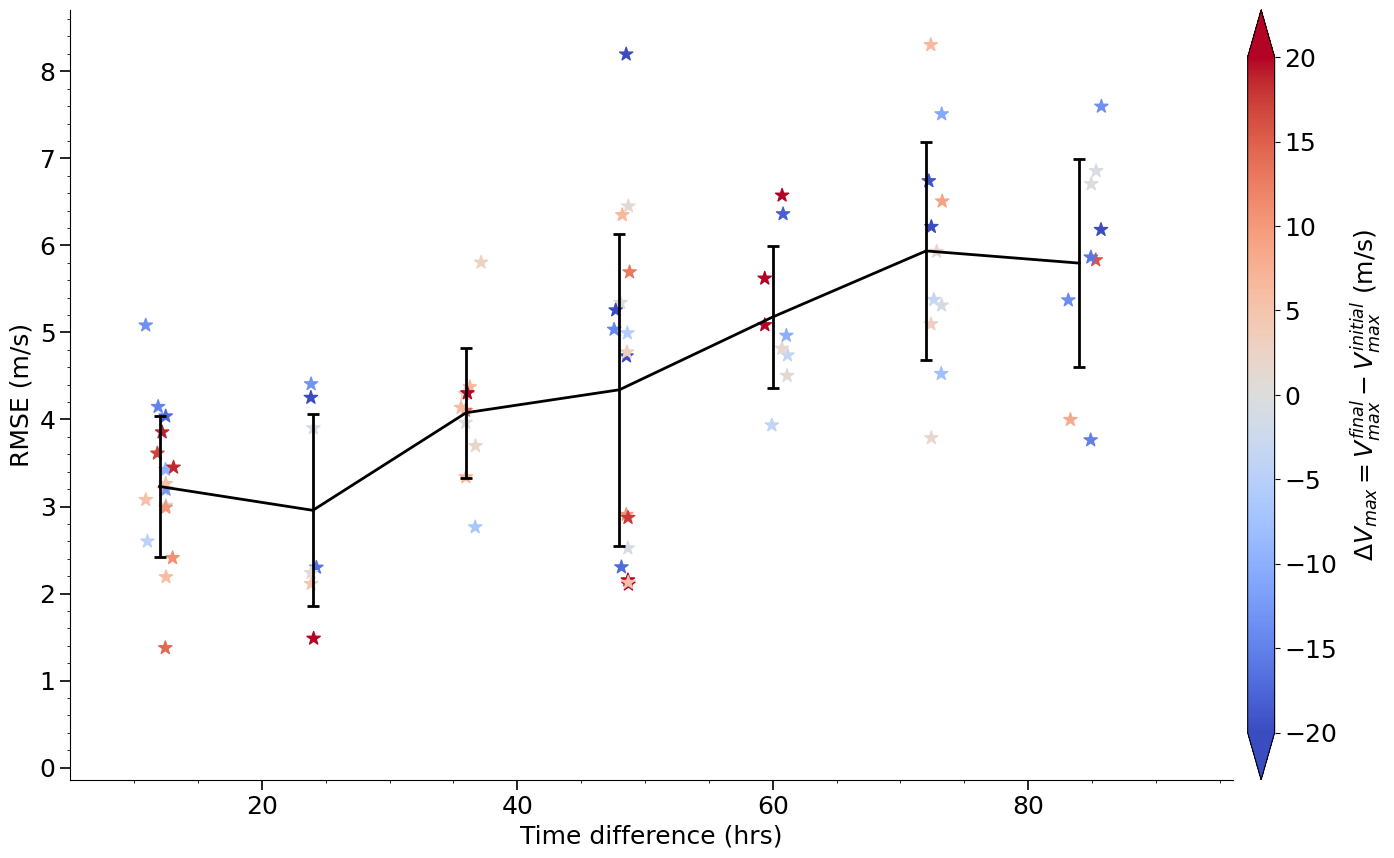

In [116]:
fig = plt.figure(figsize=(15, 10))
gs  = GridSpec(1, 1, hspace=0.11, wspace=0.1)
ax  = fig.add_subplot(gs[0])

sm = ax.scatter(dsf.delta_h, dsf.rmse, c=dsf.vmx_fin - dsf.vmx_ini, cmap=mpl.cm.get_cmap('coolwarm'), marker='*', s=100, vmin=-20, vmax=20)
ax.plot(mids, grps.mean().rmse, c='k', linewidth=2)
ax.errorbar(mids, grps.mean().rmse, grps.std().rmse, linestyle='None', capsize=4, capthick=2, c='k', linewidth=2)
        
# Grid, limits
ax.set_xlim(5, 96)
ax.minorticks_on();ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Time difference (hrs)');ax.set_ylabel('RMSE (m/s)')

# Colorbar
cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
# cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'$\Delta V_{max} = V_{max}^{final} - V_{max}^{initial}$ (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'error_in_time.pdf', bbox_inches='tight', format='pdf')

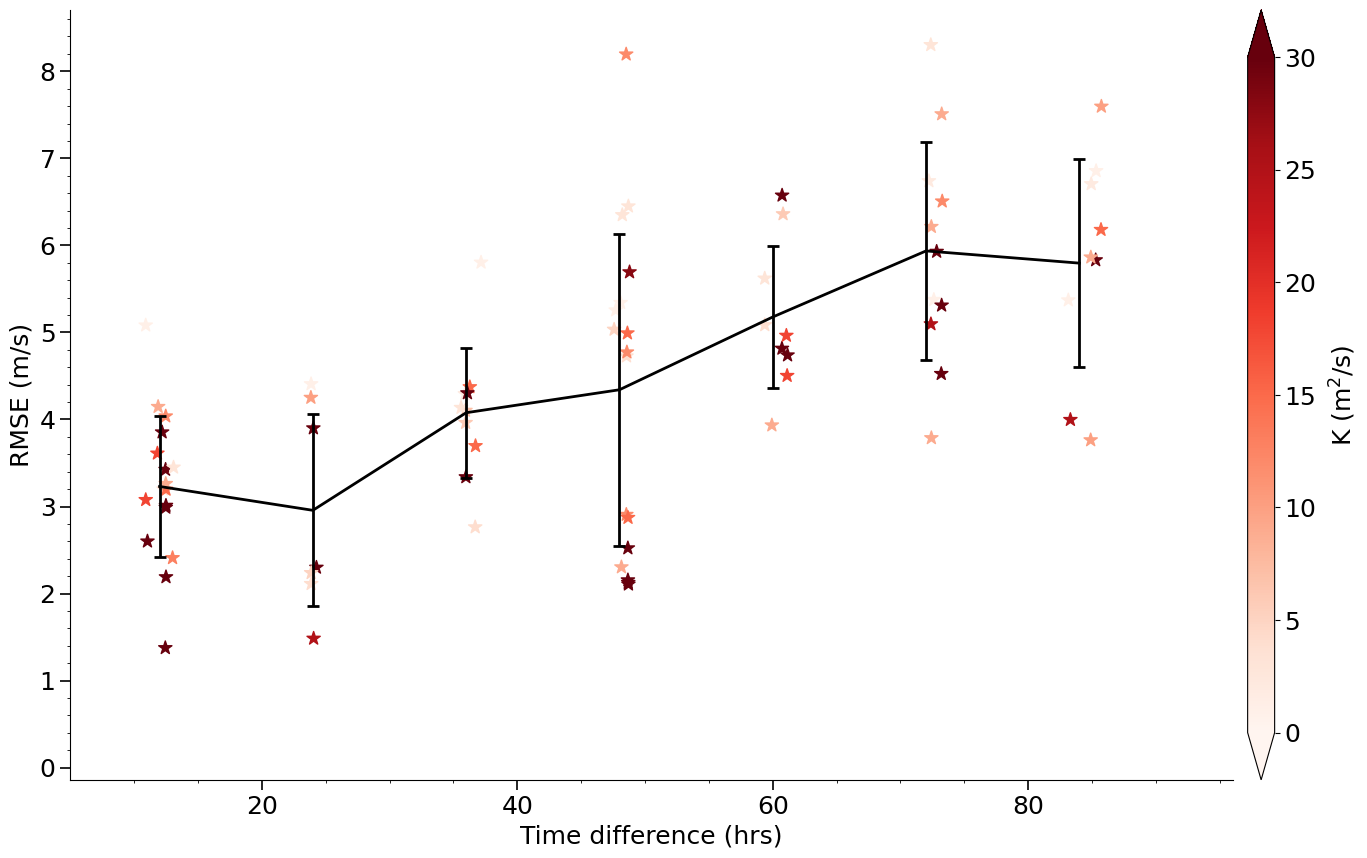

In [126]:
fig = plt.figure(figsize=(15, 10))
gs  = GridSpec(1, 1, hspace=0.11, wspace=0.1)
ax  = fig.add_subplot(gs[0])

sm = ax.scatter(dsf.delta_h, dsf.rmse, c=dsf.K, cmap=mpl.cm.get_cmap('Reds'), marker='*', s=100, vmin=0, vmax=30)
ax.plot(mids, grps.mean().rmse, c='k', linewidth=2)
ax.errorbar(mids, grps.mean().rmse, grps.std().rmse, linestyle='None', capsize=4, capthick=2, c='k', linewidth=2)
        
# Grid, limits
ax.set_xlim(5, 96)
ax.minorticks_on();ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel('Time difference (hrs)');ax.set_ylabel('RMSE (m/s)')

# Colorbar
cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
# cbar.formatter.set_powerlimits((0, 0))
cbar.set_label(r'K (m$^2$/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'error_in_time_with_K.pdf', bbox_inches='tight', format='pdf')

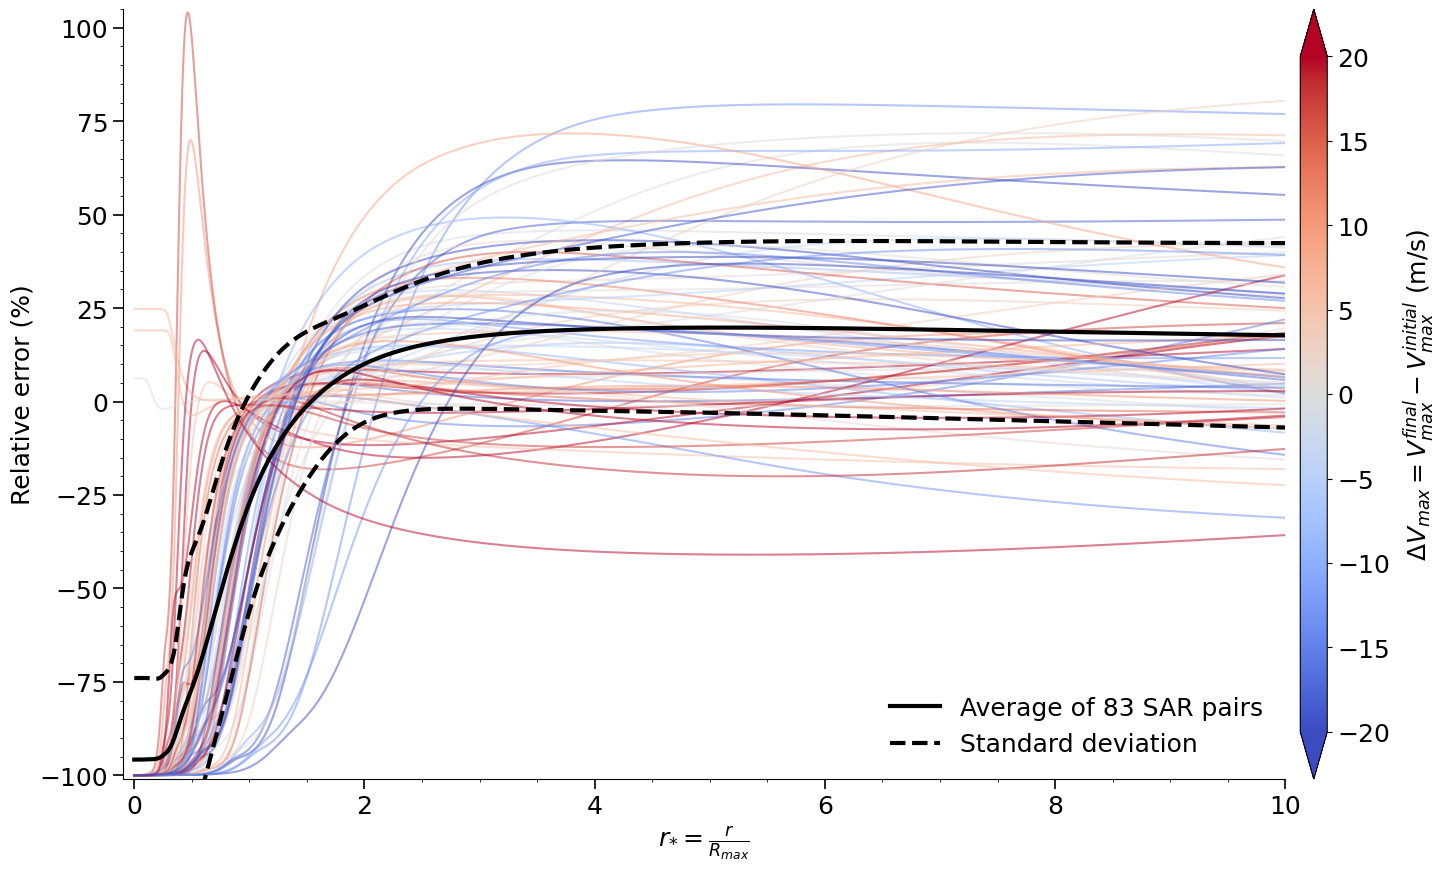

In [221]:
# Colors
c_min = -20
c_max = 20
delta_vmx = dsf.vmx_fin - dsf.vmx_ini
dsf['delta_vmx_color'] = (delta_vmx - c_min) / (c_max - c_min)

# Figure
fig = plt.figure(figsize=(15, 10))
gs  = GridSpec(1, 1, hspace=0.11, wspace=0.1)
ax  = fig.add_subplot(gs[0])

# Mean and std
ax.plot(r_ref, dsf.mean(dim='pair').rel_err * 100, linewidth=3, c='k', label='Average of {} SAR pairs'.format(len(dsf.pair)))
ax.plot(r_ref, dsf.mean(dim='pair').rel_err * 100 + dsf.std(dim='pair').rel_err * 100, linewidth=3, c='k', linestyle='dashed', label='Standard deviation')
ax.plot(r_ref, dsf.mean(dim='pair').rel_err * 100 - dsf.std(dim='pair').rel_err * 100, linewidth=3, c='k', linestyle='dashed')

# Individual errors
for p in range(len(dsf.pair)):
    ax.plot(r_ref, dsf.isel(pair=p).rel_err * 100, c=mpl.cm.get_cmap('coolwarm')(dsf.isel(pair=p)['delta_vmx_color']), alpha=0.5, zorder=0)
        
# Grid, limits
ax.set_xlim(-0.1, 10);ax.set_ylim(-101, 105)
ax.minorticks_on();ax.tick_params(length=7, width=1.2)
ax.spines[['right', 'top']].set_visible(False)
ax.set_xlabel(r'$r_{*} = \frac{r}{R_{max}}$');ax.set_ylabel(r'Relative error (%)')
ax.legend(frameon=False, loc='lower right')

# Colorbar
cb_ax = fig.add_axes([0.91, 0.11, 0.018, 0.77])
cbar  = fig.colorbar(sm, cax=cb_ax, extend='both', extendfrac=0.07, extendrect=False)
cbar.formatter.set_useMathText(True)
cbar.set_label(r'$\Delta V_{max} = V_{max}^{final} - V_{max}^{initial}$ (m/s)', rotation=90)
cbar.ax.get_yaxis().labelpad=8

if PRMS['sav_fgs']:
    plt.savefig(PTHS['sav_dir'] + 'error_in_radius.pdf', bbox_inches='tight', format='pdf')